## DSCI100 Project - Exploring the Relationship Between Player Age and Hours Played on a Research Minecraft Server

#### I) Introduction ####

Articles from *PCGamesN* and *Search Logistics* have found that the average Minecraft player is 24 years old, and those aged 15-21 make up 43% of active players in 2025. As such, explorations and predictions of player demographics surrounding age would be beneficial in bettering recruitment and targeting for video game-related research, as research groups would be able to predict whether an individual will contribute significant data. The aim of this project is to use K-nearest neighbors regression to predict whether the age of a player will contribute significant data and thus be considered a 'worthwhile' participant in future recruitment efforts. As such, the question posed is **Can we predict how much gameplay on a Minecraft server a player will contribute given player age?**


#### i) Preliminary loading of necessary libaries and setting seed

In [261]:
#loading tidyverse, tidymodels, and repr libraries
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
set.seed(9)

#### ii) Loading players.csv dataset and details

The primary dataset we will be looking at for this project is the *players.csv* dataset as it contains columns that we are interested in for algorithm prediction. *players.csv* contains columns:

- experience (chr variable type): details the experience the player has with Minecraft and/or Minecraft servers. No other information was given on how the players classified themselves on each experience type or how this was collected.
- subscribe (lgl variable type): No information was given on what this data represents or how it was collected.
- hashedEmail (chr variable type): the player's email, hashed and encrypted for privacy.
- played_hours (dbl variable type): how long, in hours, the player played on the Minecraft server. No information given on how hours were collected (whether they were the sum of total play time, etc.).
- name (chr variable type): first and/or preferred name of player.
- gender (chr variable type): gender of player.
- Age (dbl variable type): age of player at time of participation on server.


In [262]:
players<-read_csv("players.csv") #only using the players.csv data set
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


In [263]:
#Cleaning dataset to only include played hours and age
#Enssures that no NA values are present in data, and selecting the appropriate columns for use in prediction
playerdemog<-players|>
    select(played_hours, Age, gender)|>
    na.omit()|>
    arrange(-played_hours)
playerdemog

tail(playerdemog)
head(playerdemog)

played_hours,Age,gender
<dbl>,<dbl>,<chr>
223.1,17,Male
218.1,20,Non-binary
178.2,19,Female
150.0,16,Female
56.1,23,Male
⋮,⋮,⋮
0,17,Female
0,17,Male
0,20,Male


played_hours,Age,gender
<dbl>,<dbl>,<chr>
0,17,Male
0,17,Female
0,17,Male
0,20,Male
0,17,Female
0,17,Prefer not to say


played_hours,Age,gender
<dbl>,<dbl>,<chr>
223.1,17,Male
218.1,20,Non-binary
178.2,19,Female
150.0,16,Female
56.1,23,Male
53.9,17,Male


We wish to perform a preliminary exploration of the data, and the best way to do this is to make a scatterplot visualization of player age vs played hours of the original data set. However, due to the extremely wide distribution of data in terms of played_hours, it is better to plot player age vs log of played hours to ensure easier comprehensibility in the visualization.

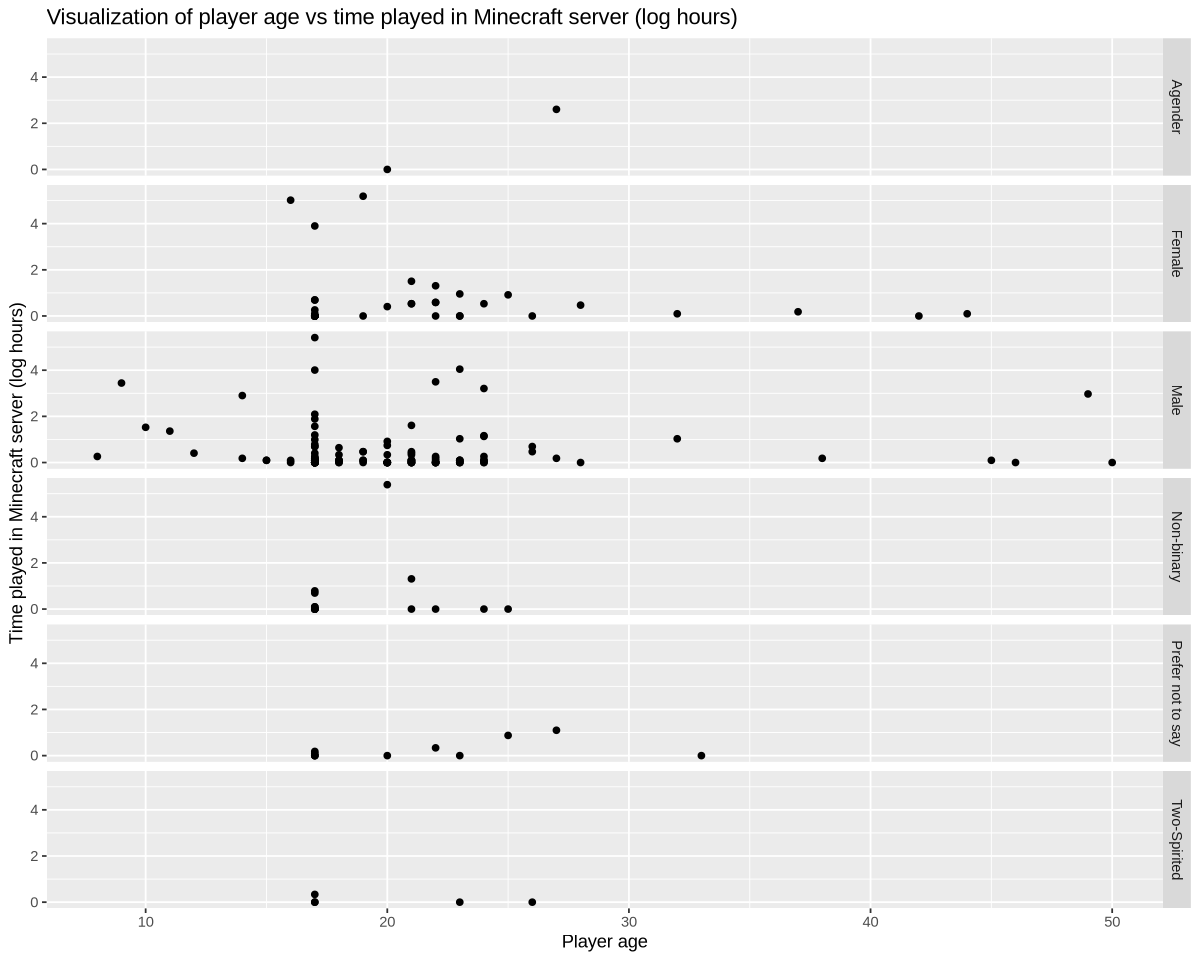

In [264]:
#Converting played_hours to log_played_hours for better data plotting visualization
explore_playerdemog<-playerdemog|>
    mutate(log_hours=log(1+played_hours))


#Scatterplot of log_played_hours and age
options(repr.plot.width=10, repr.plot.length=7) #Adjusting size of plot

explore_table<-explore_playerdemog|>
    ggplot(aes(x=Age, y=log_hours))+
    geom_point()+
    facet_grid(vars(rows=gender))+
    labs(x="Player age", y="Time played in Minecraft server (log hours)")+
    ggtitle("Visualization of player age vs time played in Minecraft server (log hours)")
explore_table

In [265]:
#assigning genders to numerical values for easier scaling
playerdemog$gender<-as.integer(factor(playerdemog$gender))
playerdemog


played_hours,Age,gender
<dbl>,<dbl>,<int>
223.1,17,3
218.1,20,4
178.2,19,2
150.0,16,2
56.1,23,3
⋮,⋮,⋮
0,17,2
0,17,3
0,20,3


Gender-numeric assignment: 

1) Agender
2) Female
3) Male
4) Non-Binary
5) Two-Sprited
6) Prefer not to say

In [266]:
#using KNN regression to determine how much a player of a certain gender and age 
#will be doing a 5 fold cross validation on the data set TO DETERMINE THE BEST K
#data should be split into training and testing

#split data into training and testing data sets, 70:30 in training:testing 
isplit<-initial_split(playerdemog, prop=0.7, strata=played_hours)
player_training<-training(isplit)
player_testing<-testing(isplit)

#forming a recipe 
hour_recipe<-recipe(played_hours ~., data=player_training)|>  #using all predictors in the dataset
    step_scale(all_predictors())|> 
    step_center(all_predictors()) 

#forming a tuning model to determine best k
tune_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("regression") #doing a regression algorithm to predict played hours

#5-fold cross-validation
#folds are created in a random way, so re-running this code would result in slight differences in prediction estimates
vfold<-vfold_cv(player_training, v=5, strata=played_hours)


#developing a fit
tune_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(tune_spec)


#setting a range of k=1-10 to find the best k
kvals<-tibble(neighbors=seq(from=1, to=10, by=1))

#collecting data to find the smallest RMSE
kvals_result<-tune_fit|>
    tune_grid(resamples=vfold, grid=kvals)|>
    collect_metrics()|>
    filter(.metric=="rmse")
kvals_result

# finding k value with minimum rmse for use in testing model
kvals_min<-kvals_result|>
   slice_min(mean, n=1)|>#finds the row with the minimum mean
    pull(neighbors)
kvals_min


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,31.81063,5,10.131891,Preprocessor1_Model01
2,rmse,standard,30.79858,5,9.629263,Preprocessor1_Model02
3,rmse,standard,33.27769,5,8.056383,Preprocessor1_Model03
4,rmse,standard,34.12947,5,7.353616,Preprocessor1_Model04
5,rmse,standard,33.37994,5,7.760643,Preprocessor1_Model05
6,rmse,standard,32.41899,5,8.061349,Preprocessor1_Model06
7,rmse,standard,32.34742,5,7.978262,Preprocessor1_Model07
8,rmse,standard,31.74127,5,8.067537,Preprocessor1_Model08
9,rmse,standard,31.95110,5,7.913146,Preprocessor1_Model09


[1] 2

In [267]:
#Assess RMSPE on testing data
#Using same recipe, hour_recipe

#Must make new model using the testing data
kmin_spec<-nearest_neighbor(weight_func="rectangular", neighbors=kvals_min)|>
    set_engine("kknn")|>
    set_mode("regression")

kmin_fit<-workflow()|>
    add_recipe(hour_recipe)|>
    add_model(kmin_spec)|>
    fit(data=player_testing) #fitting onto the testing data

#forming predictions on testing data


In [268]:
#finding RMSPE for testing data -- testing algorithm on predicting unseen data
hour_summary<-kmin_fit|>
    predict(player_testing)|>
    bind_cols(player_testing)|>
    metrics(truth=played_hours, estimate=.pred)|>
    filter(.metric=="rmse")
hour_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.96035


In [269]:

hour_preds<-kmin_fit|>
    predict(player_training)|> #create predictions for training data
    bind_cols(player_training) #binding predictions to the actual data in the TRAINING DATA SET
hour_preds


.pred,played_hours,Age,gender
<dbl>,<dbl>,<dbl>,<int>
0.25,0.1,21,3
0.50,0.1,17,2
0.25,0.1,21,3
1.10,0.1,17,4
0.25,0.1,21,3
⋮,⋮,⋮,⋮
0.50,1.0,17,2
11.95,1.0,26,3
0.25,0.9,18,3


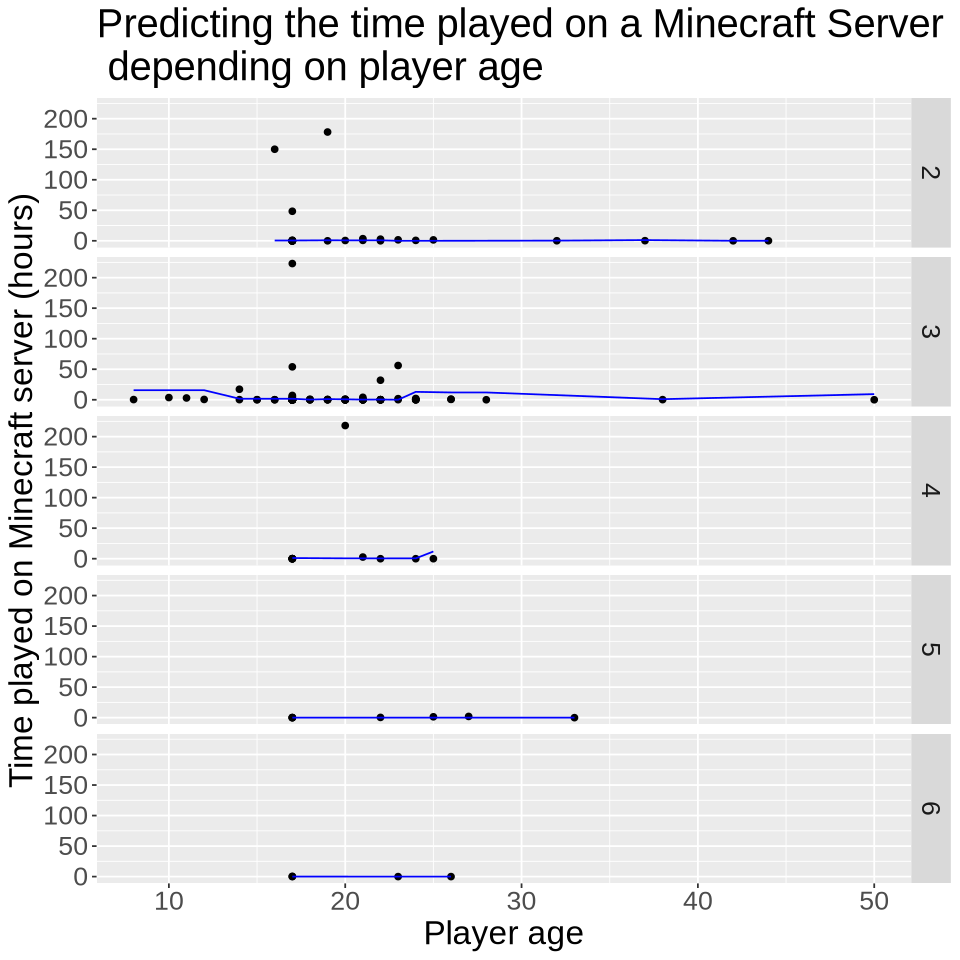

In [270]:
#plotting algorithm on testing data

options(repr.plot.width=8, repr.plot.height=8)

player_preds<-hour_preds|>
    ggplot()+
    geom_point(aes(x=Age, y=played_hours)) + #plotting training data as a scatter plot
    geom_line(data=hour_preds, #plotting predictions as a blue line on the scatterplot
              mapping=aes(x=Age, y=.pred),
            color="blue")+
    facet_grid(vars(rows=gender))+
    labs(x="Player age", y="Time played on Minecraft server (hours)", title="Predicting the time played on a Minecraft Server\n depending on player age")+
    theme(text=element_text(size=20))

player_preds


In [271]:
#2 for 8h